In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
numerical_summary = data.describe()
numerical_summary

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [4]:
categorical_distribution = data.describe(include=['O'])
categorical_distribution

,date,country,store,product
count,136950,136950,136950,136950
unique,1826,5,3,5
top,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,75,27390,45650,27390


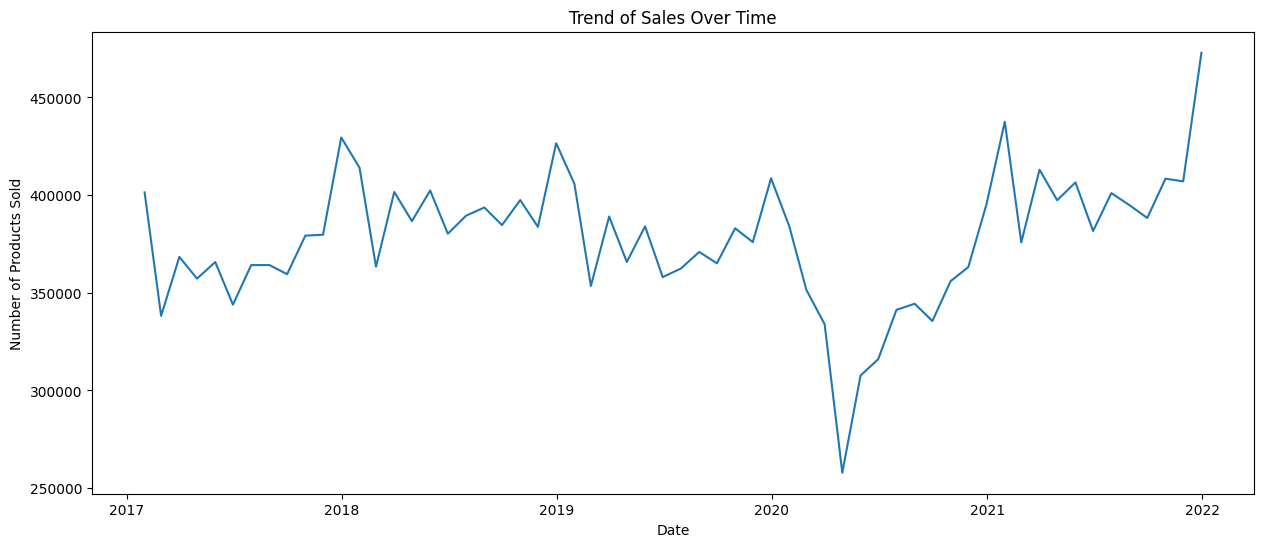

In [5]:
data['date'] = pd.to_datetime(data['date'])

# Aggregate sales on a monthly basis
monthly_sales = data.resample('M', on='date').sum()['num_sold']

# Plot the trend of sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Trend of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

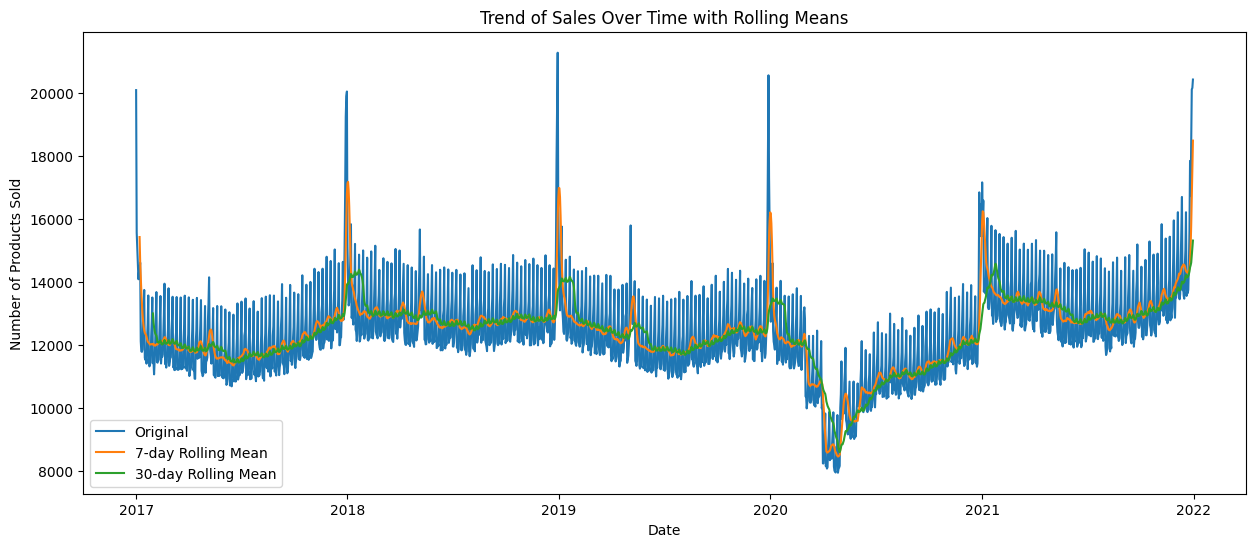

In [7]:
daily_sales = data.resample('D', on='date').sum()['num_sold']

daily_sales_rolling_7d = daily_sales.rolling(window=7).mean()
daily_sales_rolling_30d = daily_sales.rolling(window=30).mean()

# Plot the original daily sales and the rolling means
plt.figure(figsize=(15, 6))
sns.lineplot(x=daily_sales.index, y=daily_sales.values, label='Original')
sns.lineplot(x=daily_sales_rolling_7d.index, y=daily_sales_rolling_7d.values, label='7-day Rolling Mean')
sns.lineplot(x=daily_sales_rolling_30d.index, y=daily_sales_rolling_30d.values, label='30-day Rolling Mean')
plt.title('Trend of Sales Over Time with Rolling Means')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend()
plt.show()

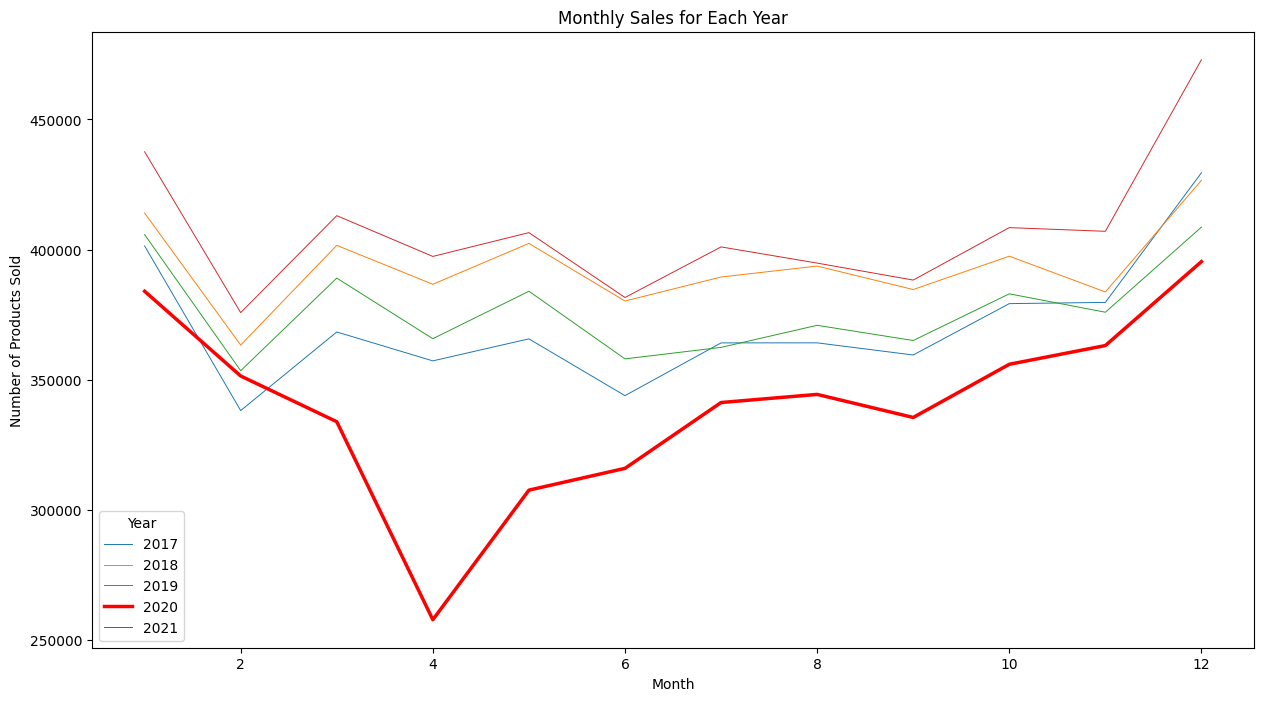

In [8]:
# Aggregate sales on a monthly basis for each year
monthly_sales_year = data.resample('M', on='date').sum()['num_sold'].reset_index()

# Create a column for the year
monthly_sales_year['year'] = monthly_sales_year['date'].dt.year

# Create a line plot for each year
plt.figure(figsize=(15, 8))
for year in sorted(monthly_sales_year['year'].unique()):
    year_data = monthly_sales_year[monthly_sales_year['year'] == year]
    if year == 2020:
        sns.lineplot(x=year_data['date'].dt.month, y=year_data['num_sold'], label=year, linewidth=2.5, color='red')
    else:
        sns.lineplot(x=year_data['date'].dt.month, y=year_data['num_sold'], label=year, linewidth=0.7)
plt.title('Monthly Sales for Each Year')
plt.xlabel('Month')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.show()

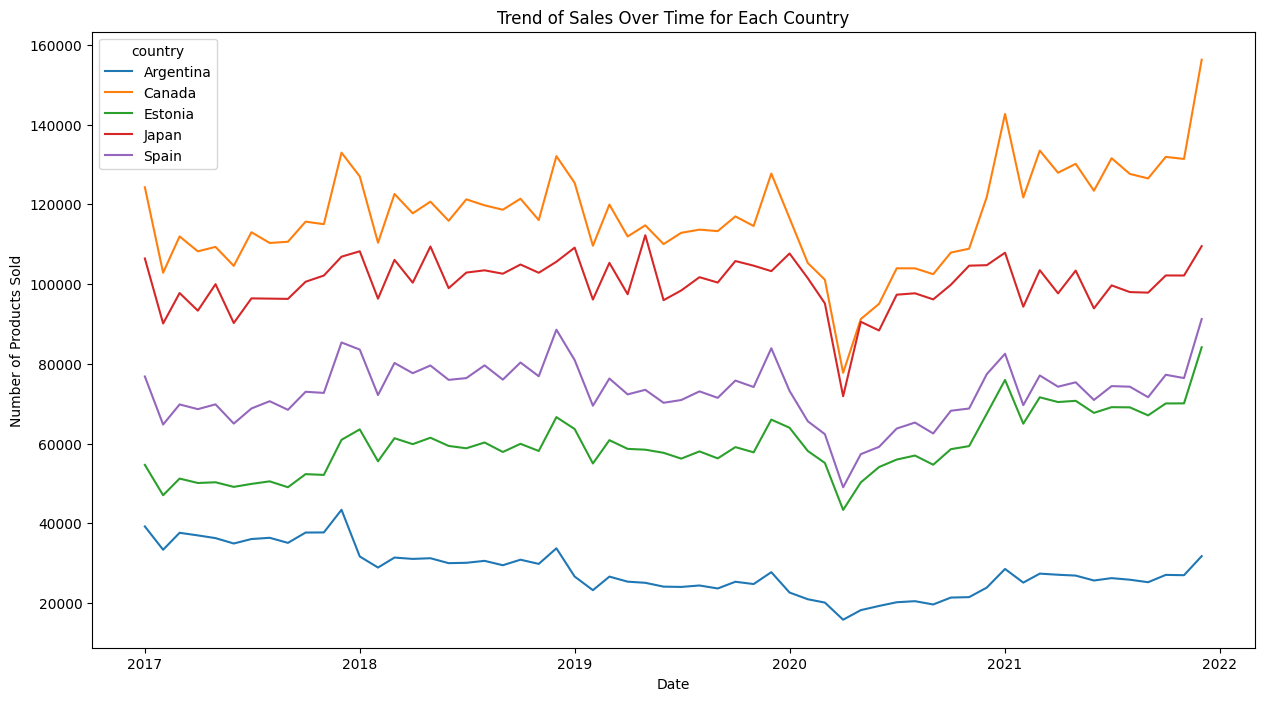

In [10]:
monthly_sales_country = data.groupby([data['date'].dt.to_period('M'), 'country'])['num_sold'].sum().reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()

# Create a line plot for each country
plt.figure(figsize=(15, 8))
sns.lineplot(data=monthly_sales_country, x='date', y='num_sold', hue='country')
plt.title('Trend of Sales Over Time for Each Country')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

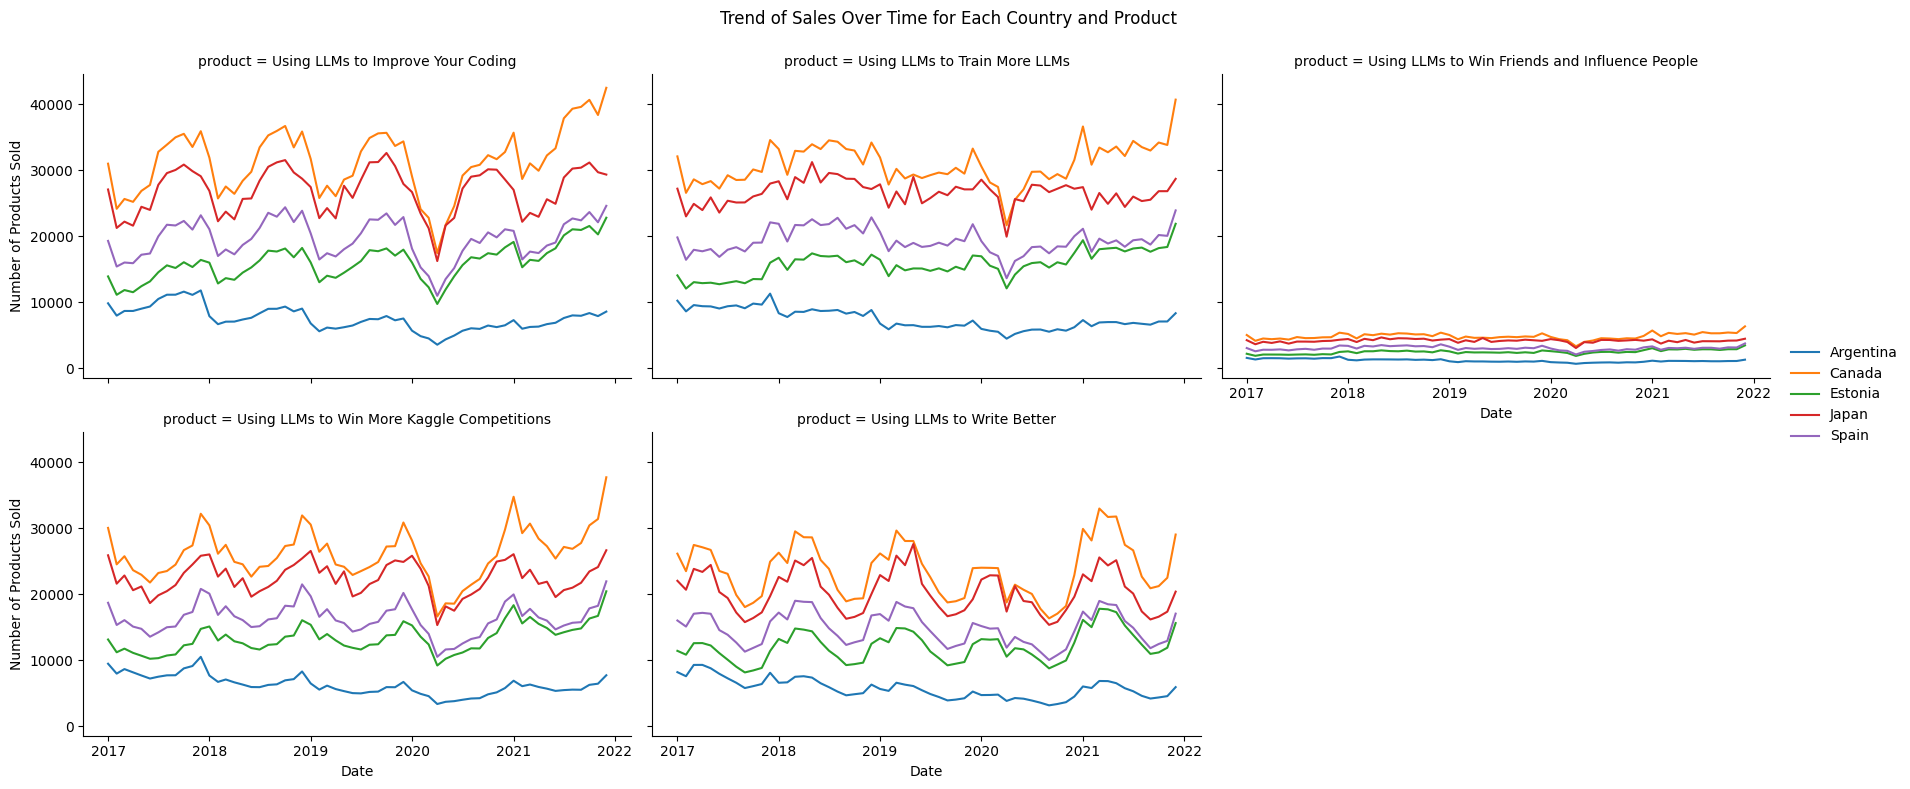

In [11]:
monthly_sales_country_product = data.groupby([data['date'].dt.to_period('M'), 'country', 'product'])['num_sold'].sum().reset_index()
monthly_sales_country_product['date'] = monthly_sales_country_product['date'].dt.to_timestamp()

# Create a FacetGrid to make a separate line plot for each product
g = sns.FacetGrid(monthly_sales_country_product, col='product', col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='date', y='num_sold', hue='country')
g.set_axis_labels('Date', 'Number of Products Sold')
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend of Sales Over Time for Each Country and Product')
plt.show()

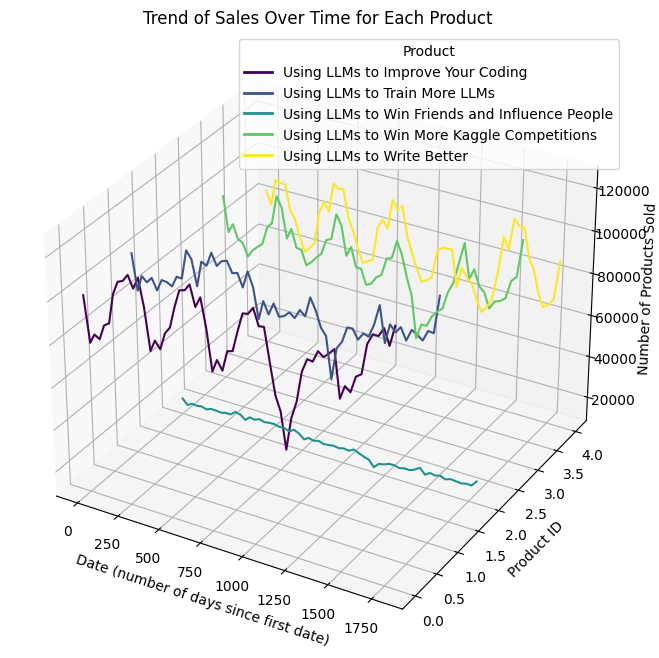

In [13]:
monthly_sales_product = data.groupby([data['date'].dt.to_period('M'), 'product'])['num_sold'].sum().reset_index()
monthly_sales_product['date'] = monthly_sales_product['date'].dt.to_timestamp()

# Assign each product a unique numeric ID
product_ids = {product: i for i, product in enumerate(monthly_sales_product['product'].unique())}
monthly_sales_product['product_id'] = monthly_sales_product['product'].map(product_ids)

# Convert 'date' to a numeric form (number of days since the first date)
monthly_sales_product['date_num'] = (monthly_sales_product['date'] - monthly_sales_product['date'].min()).dt.days


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the different products
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_sales_product['product'].unique())))


# Plot a line for each product
for i, product in enumerate(monthly_sales_product['product'].unique()):
    product_data = monthly_sales_product[monthly_sales_product['product'] == product]
    ax.plot(product_data['date_num'], product_data['product_id'], product_data['num_sold'], color=colors[i])

# Set the labels and title
ax.set_xlabel('Date (number of days since first date)')
ax.set_ylabel('Product ID')
ax.set_zlabel('Number of Products Sold')
ax.set_title('Trend of Sales Over Time for Each Product')

ax.legend([plt.Line2D([0], [0], color=color, lw=2) for color in colors],
          product_ids.keys(),
          title='Product',
          loc='upper right')

plt.show()

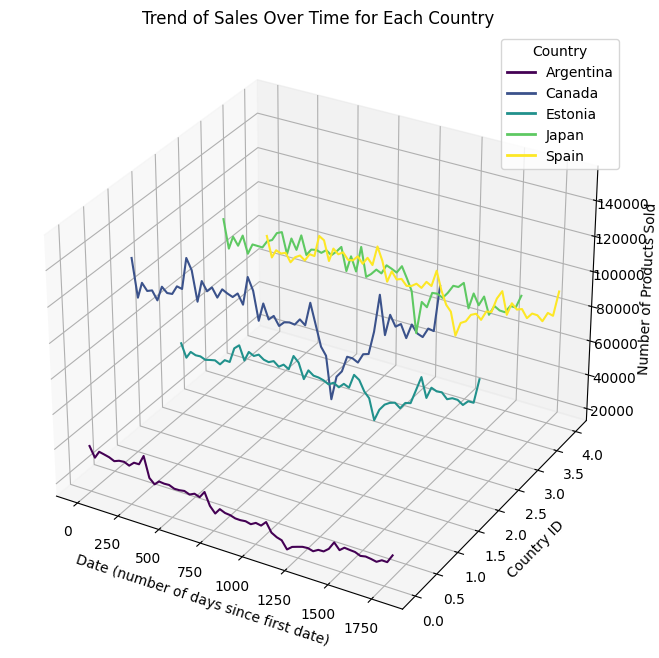

In [15]:
country_ids = {country: i for i, country in enumerate(data['country'].unique())}
data['country_id'] = data['country'].map(country_ids)


# Aggregate sales on a monthly basis for each country
monthly_sales_country = data.groupby([data['date'].dt.to_period('M'), 'country'])['num_sold'].sum().reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()
monthly_sales_country['country_id'] = monthly_sales_country['country'].map(country_ids)

# Convert 'date' to a numeric form (number of days since the first date)
monthly_sales_country['date_num'] = (monthly_sales_country['date'] - monthly_sales_country['date'].min()).dt.days

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a line for each country
for i, country in enumerate(monthly_sales_country['country'].unique()):
    country_data = monthly_sales_country[monthly_sales_country['country'] == country]
    ax.plot(country_data['date_num'], country_data['country_id'], country_data['num_sold'], color=colors[i])

# Set the labels and title
ax.set_xlabel('Date (number of days since first date)')
ax.set_ylabel('Country ID')
ax.set_zlabel('Number of Products Sold')
ax.set_title('Trend of Sales Over Time for Each Country')

ax.legend([plt.Line2D([0], [0], color=color, lw=2) for color in colors],
          country_ids.keys(),
          title='Country',
          loc='upper right')

plt.show()

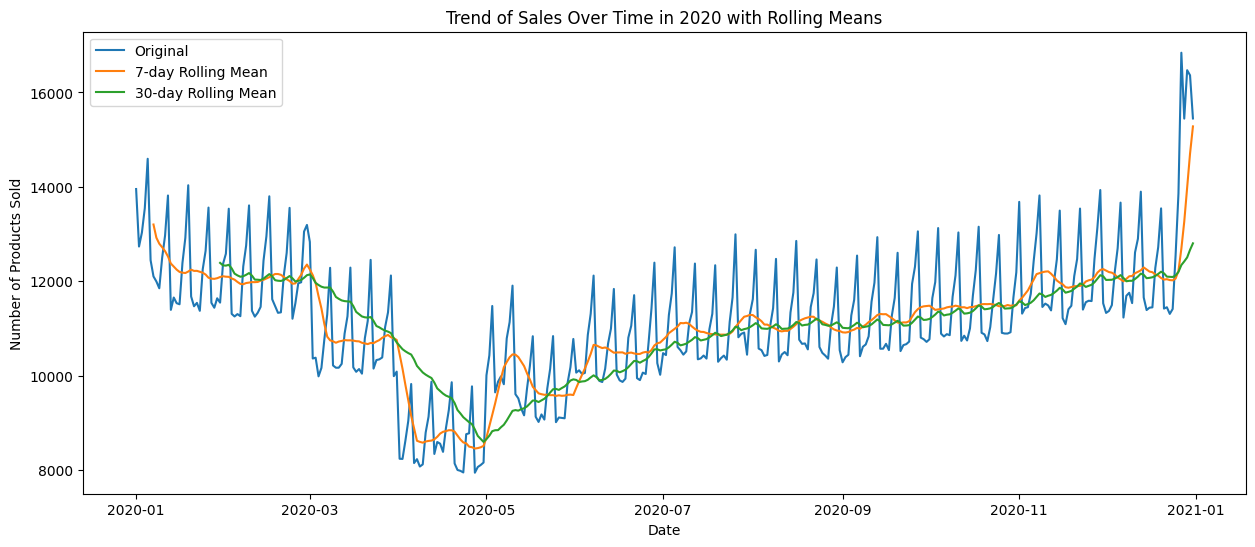

In [16]:
# Filter the data for the year 2020
data_2020 = data[(data['date'].dt.year == 2020)]

# Aggregate sales on a daily basis

daily_sales_2020 = data_2020.resample('D', on='date').sum()['num_sold']

# Calculate 7-day and 30-day rolling means
daily_sales_2020_rolling_7d = daily_sales_2020.rolling(window=7).mean()
daily_sales_2020_rolling_30d = daily_sales_2020.rolling(window=30).mean()

# Plot the original daily sales and the rolling means
plt.figure(figsize=(15, 6))
sns.lineplot(x=daily_sales_2020.index, y=daily_sales_2020.values, label='Original')
sns.lineplot(x=daily_sales_2020_rolling_7d.index, y=daily_sales_2020_rolling_7d.values, label='7-day Rolling Mean')
sns.lineplot(x=daily_sales_2020_rolling_30d.index, y=daily_sales_2020_rolling_30d.values, label='30-day Rolling Mean')
plt.title('Trend of Sales Over Time in 2020 with Rolling Means')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend()
plt.show()

In [18]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor


import holidays
import dateutil.easter as easter

In [20]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [21]:
# Convert 'date' column to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Extract date info
train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month
train['Day'] = train['date'].dt.day
train['WeekDay'] = train['date'].dt.dayofweek

test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day
test['WeekDay'] = test['date'].dt.dayofweek

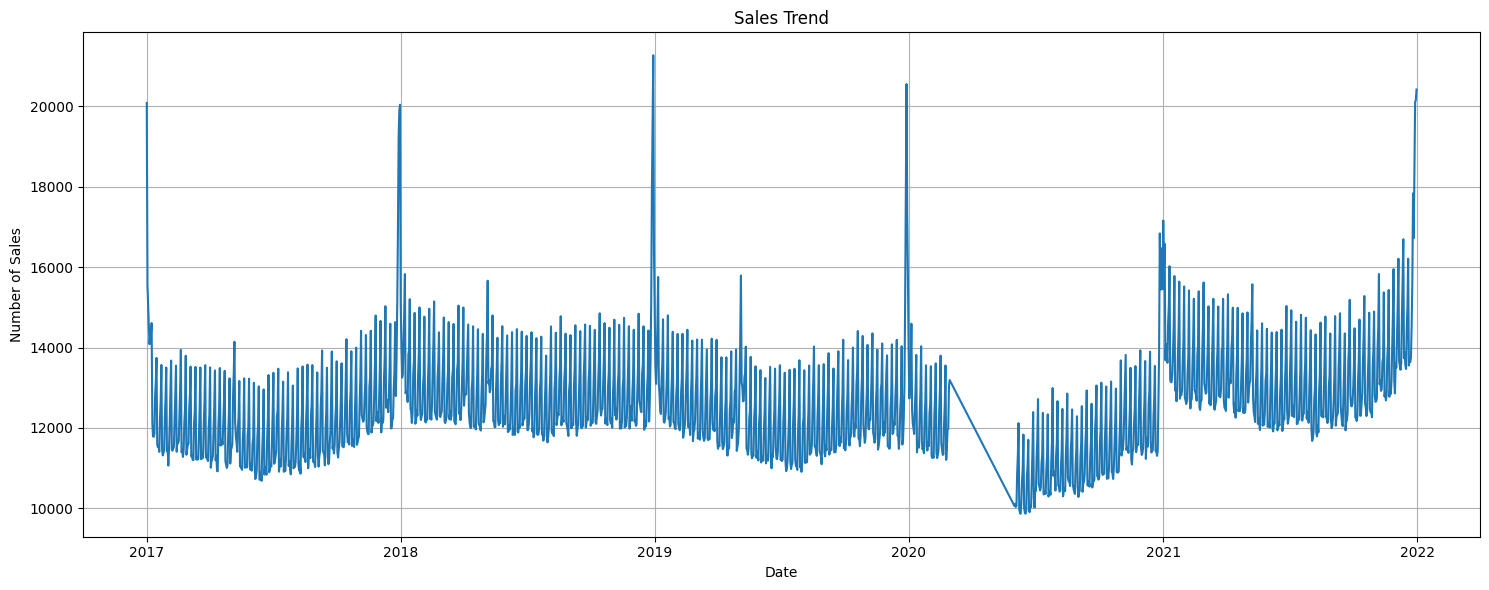

In [22]:
temp = train.loc[~((train["date"] >= "2020-03-01") & (train["date"] < "2020-06-01"))].copy()  # Remove data from March 2020 to May 2020
train_agg = temp.groupby("date")["num_sold"].sum().reset_index()


plt.figure(figsize=(15, 6))
sns.lineplot(data=train_agg, x="date", y="num_sold")
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.title("Sales Trend")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
test_agg = test.groupby(["date"])["id"].first().reset_index().drop(columns="id")
test_dates = test_agg[["date"]]

In [24]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years=years_list)
    holiday_CA = holidays.CountryHoliday('CA', years=years_list)
    holiday_EE = holidays.CountryHoliday('EE', years=years_list)
    holiday_JP = holidays.CountryHoliday('JP', years=years_list)
    holiday_ES = holidays.CountryHoliday('ES', years=years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_EE)
    holiday_dict.update(holiday_JP)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')

    return df

def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

def apply_sin_cos_transformation(df, col_name, period):
    df[f'{col_name}_sin'] = np.sin(df[col_name] * (2 * np.pi / period))
    df[f'{col_name}_cos'] = np.cos(df[col_name] * (2 * np.pi / period))
    return df
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    new_df["year"] = df["date"].dt.year
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [25]:

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_agg = get_holidays(train_agg)
test_agg = get_holidays(test_agg)

train_pred = pd.DataFrame()
train_pred['date'] = train_agg['date']

y_train = train_agg["num_sold"]
X_train = train_agg.drop(columns="num_sold")
X_test = test_agg

X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

X_train = encode_holiday_names(X_train, oe)
X_test = encode_holiday_names(X_test, oe)

In [26]:
def train_and_predict(X_train, y_train, X_test):
    preds_lst = []
    n_splits = 5
    kf = GroupKFold(n_splits=n_splits)
    scores = []
    train_scores = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
        model = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[train_idx]), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_train.iloc[val_idx]), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train_scaled, y_train.iloc[train_idx])
        preds_lst.append(model.predict(X_test_scaled))
        train_scores[val_idx] = model.predict(X_val_scaled)
        sc = model.score(X_val_scaled, y_train.iloc[val_idx])
        scores.append(sc)
        print(f"Fold {fold}: Score = {sc}")

    mean_score = np.mean(scores)
    print("Mean score:", mean_score)
    return preds_lst, train_scores

preds_lst, train_scores = train_and_predict(X_train, y_train, X_test)
train_pred['num_sold'] = train_scores

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1369, number of used features: 9
[LightGBM] [Info] Start training from score 12333.441928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [27]:
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns=["2017", "2018", "2019", "2020", '2021'])

# Calculate average predictions from k-fold
preds_df['num_sold'] = preds_df.mean(axis=1)

# Assign predictions to test_dates DataFrame
test_dates["num_sold"] = preds_df['num_sold']

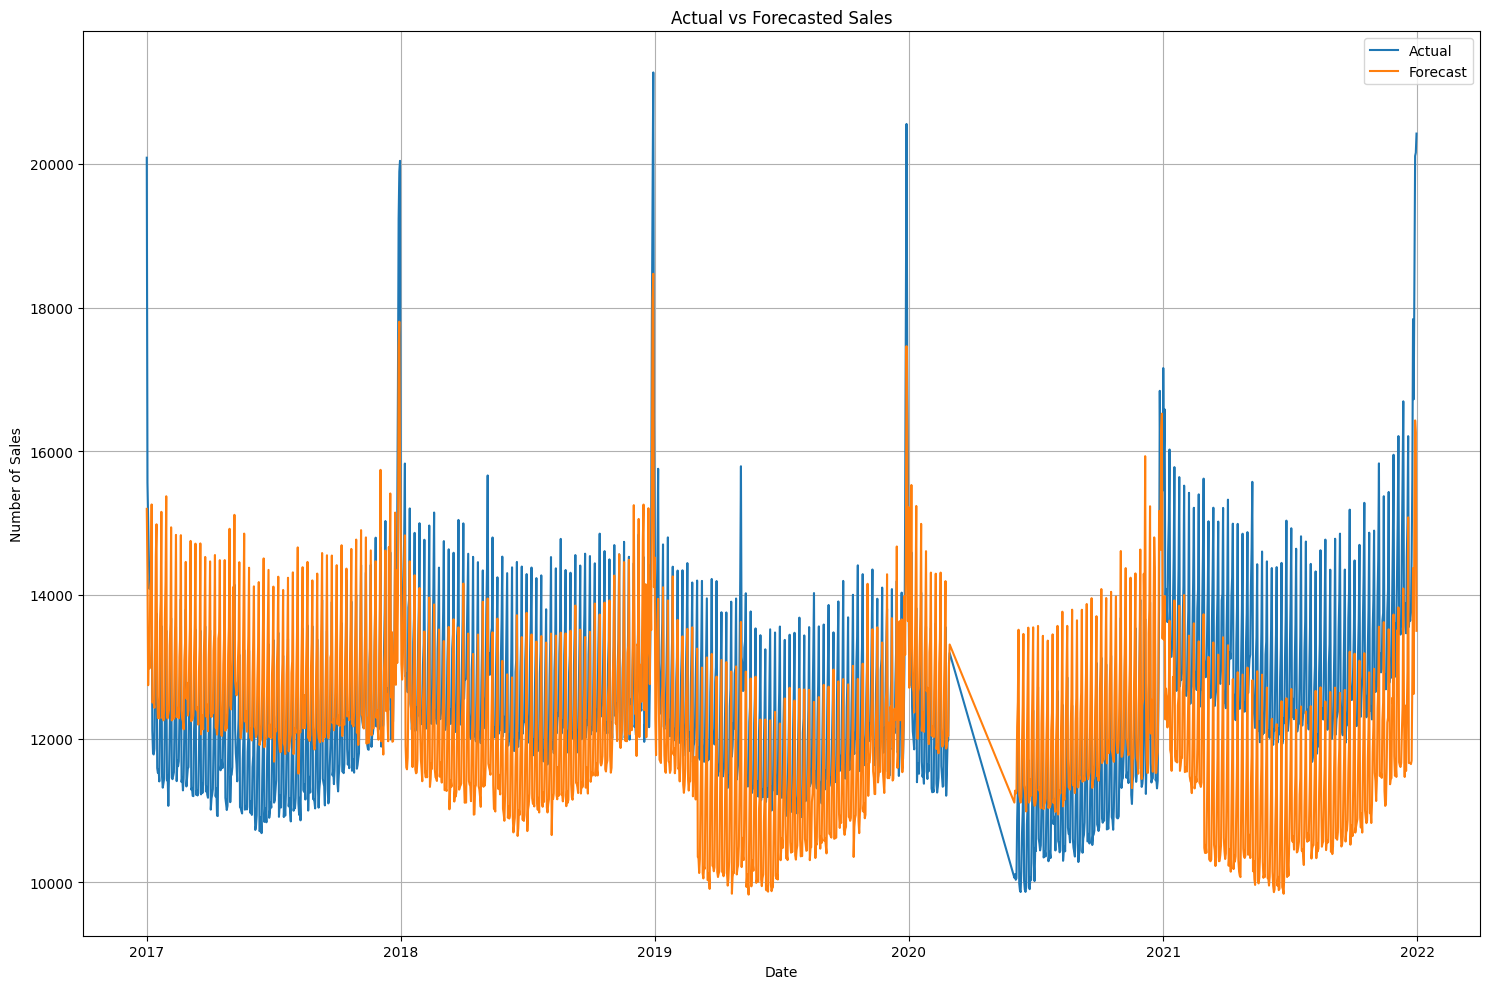

In [28]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="date", y="num_sold", label='Actual')
sns.lineplot(data=train_pred, x='date', y='num_sold', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

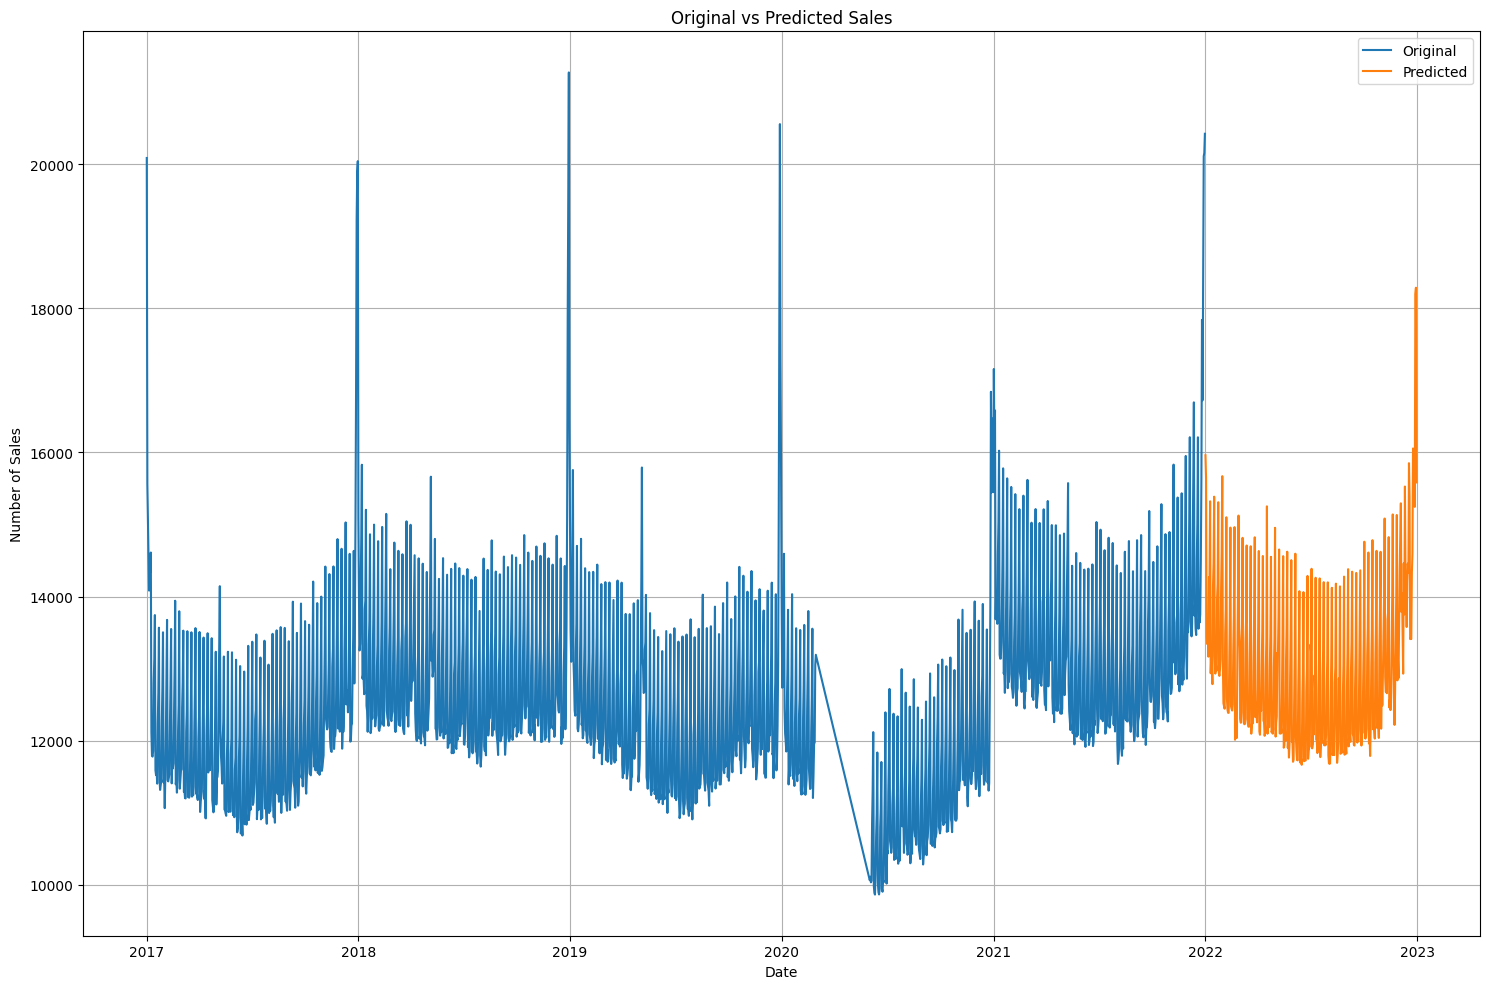

In [29]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="date", y="num_sold", label='Original')
sns.lineplot(data=test_dates, x="date", y="num_sold", label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Original vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df

,date,product,ratios
0,2017-01-01,Using LLMs to Improve Your Coding,0.255452
1,2017-01-01,Using LLMs to Train More LLMs,0.254058
2,2017-01-01,Using LLMs to Win Friends and Influence People,0.039381
3,2017-01-01,Using LLMs to Win More Kaggle Competitions,0.253211
4,2017-01-01,Using LLMs to Write Better,0.197899
...,...,...,...
9125,2021-12-31,Using LLMs to Improve Your Coding,0.263001
9126,2021-12-31,Using LLMs to Train More LLMs,0.263686
9127,2021-12-31,Using LLMs to Win Friends and Influence People,0.039957
9128,2021-12-31,Using LLMs to Win More Kaggle Competitions,0.241015


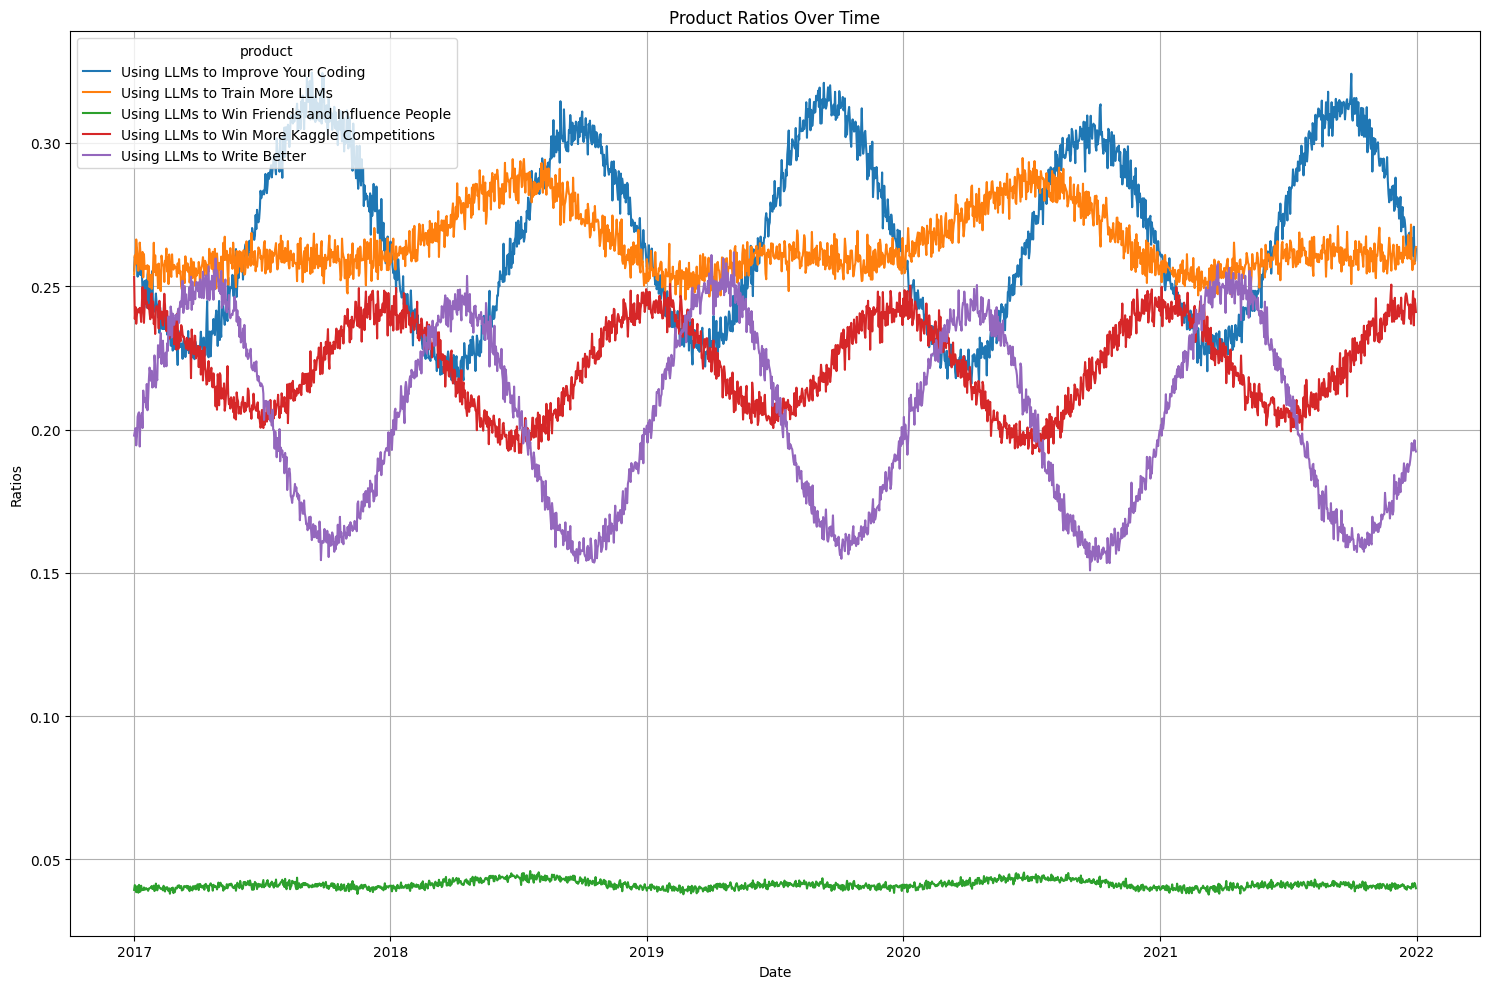

In [32]:
temp_df = pd.concat([product_ratio_df, test_agg]).reset_index(drop=True)

plt.figure(figsize=(15, 10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product")
plt.xlabel("Date")
plt.ylabel("Ratios")
plt.title("Product Ratios Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
mean_ratios = []
years = train['Year'].unique()
years.sort()  # ensuring years are sorted
years = years[:-2]  # remove last two years
assert len(years) > 0, "There should be at least one year to compute mean_ratios"

weights = [0.2, 0.4, 0.4]  # you can change these weights according to your need
assert len(weights) == len(years), "Weights count should match with the years count"

for year in years:
    product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == year].copy()
    product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
    product_ratio_2019 = product_ratio_2019.drop(columns="date")
    product_ratio_2019 = product_ratio_2019.reset_index()
    mean_ratios.append(product_ratio_2019['ratios'])

product_ratio_test = test.copy()

# Now product_ratio_2019 is defined and can be used here
product_ratio_2019['mean_ratios'] = sum(mean_ratio * weight for mean_ratio, weight in zip(mean_ratios, weights))

product_ratio_test["mm-dd"] = product_ratio_test["date"].dt.strftime('%m-%d')
product_ratio_test = pd.merge(product_ratio_test, product_ratio_2019, how="left", on=["mm-dd", "product"])
product_ratio_test

,id,date,country,store,product,Year,Month,Day,WeekDay,mm-dd,index,ratios,mean_ratios
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,01-01,3650,0.256706,0.260007
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,01-01,3651,0.259442,0.258146
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,01-01,3652,0.039103,0.039814
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,01-01,3653,0.243360,0.242481
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,01-01,3654,0.201388,0.199552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,12-31,5470,0.260448,0.260866
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,12-31,5471,0.266844,0.258673
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,12-31,5472,0.041223,0.040659
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,12-31,5473,0.236449,0.242341


In [34]:
test_data = pd.merge(test, test_dates, how="left")
test_data["ratios"] = product_ratio_test["mean_ratios"]
test_data

,id,date,country,store,product,Year,Month,Day,WeekDay,num_sold,ratios
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,15960.574743,0.260007
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,15960.574743,0.258146
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,15960.574743,0.039814
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,15960.574743,0.242481
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,15960.574743,0.199552
...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,15583.770936,0.260866
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,15583.770936,0.258673
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,15583.770936,0.040659
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,15583.770936,0.242341


In [35]:
def disaggregate_forecast(df, original_data):

    new_df = df.copy()
    
    # Compute weights and check for zero total sales
    total_num_sold = original_data["num_sold"].sum()

    stores_weights = original_data.groupby("store")["num_sold"].sum() / total_num_sold

    # Compute country_weights and check if all countries in df are present in original_data
    unique_countries = df["country"].unique()
    
    country_weights = pd.Series(index=unique_countries, data=1/len(unique_countries))

    # Adjust num_sold based on country and store weights
    for country in country_weights.index:
        new_df.loc[new_df["country"] == country, "num_sold"] *= country_weights[country]
                
    for store in stores_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] *= stores_weights[store]
    
    # Apply product weights and drop the "ratios" column
    new_df["num_sold"] *= new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])
    
    return new_df

In [36]:
store_weights = train.groupby("store")["num_sold"].sum()/train["num_sold"].sum()
country_weights = train.loc[train["date"] < "2021-01-01"].groupby("country")["num_sold"].sum()/train.loc[train["date"] < "2021-01-01", "num_sold"].sum()

In [37]:
final_df = disaggregate_forecast(test_data,train)
final_df

,id,date,country,store,product,Year,Month,Day,WeekDay,num_sold
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,101.0
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,100.0
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,15.0
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,94.0
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,77.0
...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,562.0
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,557.0
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,88.0
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,522.0


In [38]:
submission = pd.read_csv("./sample_submission.csv")
submission["num_sold"] = final_df["num_sold"]

submission.head()
submission.to_csv('submission.csv', index = False)